### 1. 竞赛内容

通过训练数据集分析出什么类型的人更可能幸存，并预测出测试集中的乘客是否生还。

这项竞赛属于机器学习中的二元分类问题。

### 2. 理解数据

Titanic生存预测中提供了两组数据：train.csv 和test.csv，分别是训练集和测试集。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
train_data.info()
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

### 存活比例

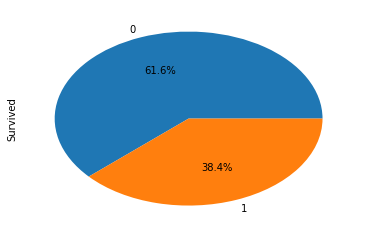

In [3]:
train_data['Survived'].value_counts().plot.pie(autopct='%1.1f%%')

### 3. 数据关系分析

### （1）性别与生存的关系



In [4]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

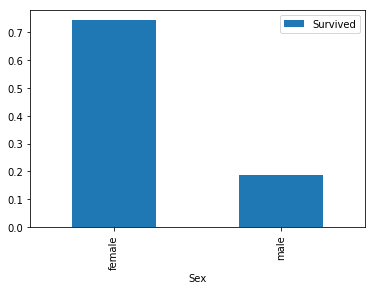

In [6]:
# 不同性别的生存率
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

### （2）船舱等级与生存的关系

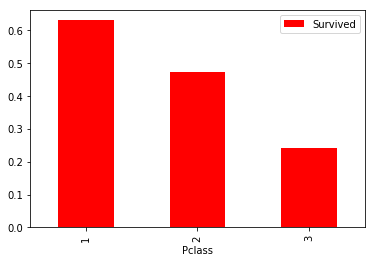

In [7]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar(color=['r','g','b'])

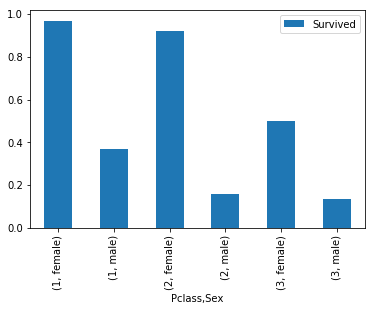

In [8]:
# 不同等级船舱的生存率
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

In [9]:
# 不同等级船舱的男女生存率

train_data.groupby(['Sex','Pclass','Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

从上图和表中明显可以看到，虽然泰坦尼克号逃生总体符合妇女优先，但是对各个等级船舱还是有区别的，而且一等舱中的男子凭借自身的社会地位强行混入了救生艇。如白星航运公司主席伊斯梅（他否决了配备48艘救生艇的想法，认为少点也没关系）则抛下他的乘客、他的船员、他的船，在最后一刻跳进可折叠式救生艇C（共有39名乘客）。

### （3）年龄与存活的关系

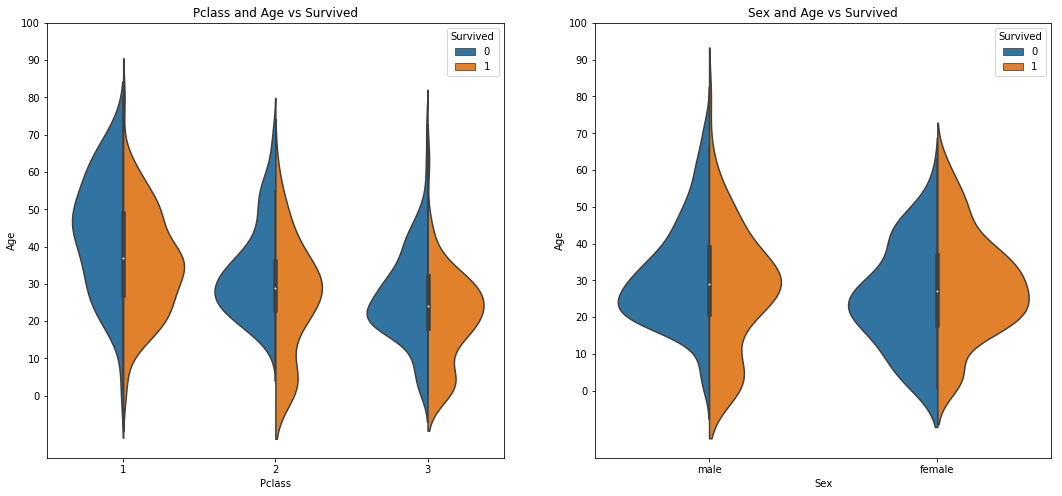

In [10]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=train_data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=train_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

### （4）称呼与存活关系

在数据的Name项中包含了对该乘客的称呼，如Mr、Miss、Mrs等，这些信息包含了乘客的年龄、性别、也有可能包含社会地位，如Dr、Lady、Major、Master等称呼。
这一项不方便用图表展示，但是在特征工程中，我们会将其加入到特征中。

### （5）登船港口与存活关系
泰坦尼克号从英国的南安普顿港出发，途径法国瑟堡和爱尔兰昆士敦，一部分在瑟堡或昆士敦下船的人逃过了一劫。

Text(0.5,1,'Embarked and Survived')

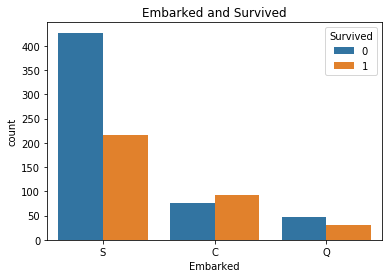

In [11]:
sns.countplot('Embarked',hue='Survived',data=train_data)
plt.title('Embarked and Survived')

### （6）船上亲友人数与存活关系

Text(0.5,1,'SibSp and Survived')

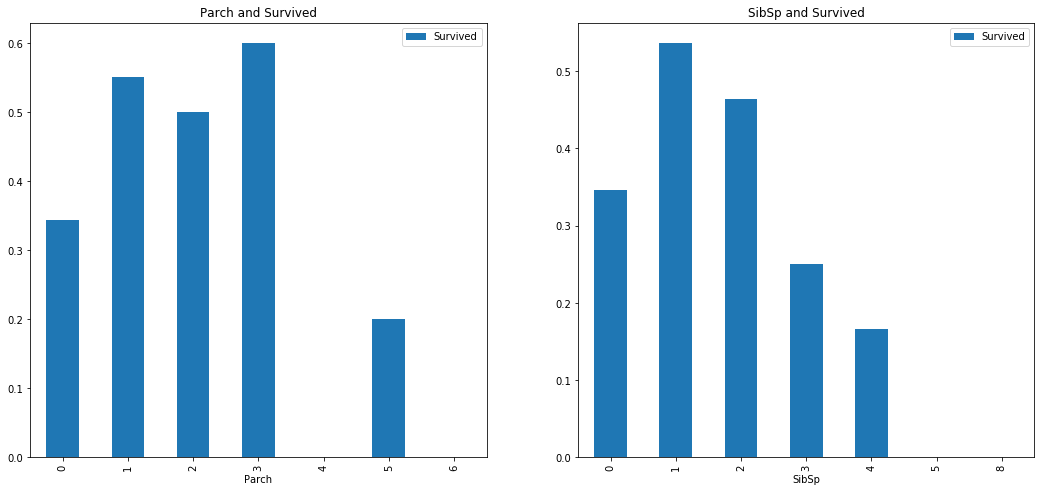

In [12]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')

### （7）其他因素
剩余因素还有船票价格、船舱号和船票号，这三个因素都可能会影响乘客在船中的位置从而影响逃生顺序，但是因为这三个因素与生存之间看不出明显规律，所以在后期模型融合时，将这些因素交给模型来决定其重要性。

### 3. 建模和预测

In [62]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn import ensemble
from sklearn import model_selection

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


'''
要建立新的特征类目
1. Fare Category
2. Pclass Fare Category
3. Family Size Category
4. Age Group Category
5. Name Length Category
'''


# 弃掉不需要的列
def drop_col_not_req(df, cols):
    df.drop(cols, axis=1, inplace=True)


# 建立Fare Category
def fare_category(fare):
    if fare <= 4:
        return 'Very_Low_Fare'
    elif fare <= 10:
        return 'Low_Fare'
    elif fare <= 30:
        return 'Med_Fare'
    elif fare <= 45:
        return 'High_Fare'
    else:
        return 'Very_High_Fare'


# 建立PClass Fare Category
def pclass_fare_category(df, Pclass_1_mean_fare, Pclass_2_mean_fare, Pclass_3_mean_fare):
    if df['Pclass'] == 1:
        if df['Fare'] <= Pclass_1_mean_fare:
            return 'Pclass_1_Low_Fare'
        else:
            return 'Pclass_1_High_Fare'
    elif df['Pclass'] == 2:
        if df['Fare'] <= Pclass_2_mean_fare:
            return 'Pclass_2_Low_Fare'
        else:
            return 'Pclass_2_High_Fare'
    elif df['Pclass'] == 3:
        if df['Fare'] <= Pclass_3_mean_fare:
            return 'Pclass_3_Low_Fare'
        else:
            return 'Pclass_3_High_Fare'


# 建立Family Size Category
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 3:
        return 'Small_Family'
    else:
        return 'Large_Family'


# 建立Age_Group_category
def age_group_category(age):
    if age <= 1:
        return 'Baby'
    elif age <= 4:
        return 'Toddler'
    elif age <= 12:
        return 'Child'
    elif age <= 19:
        return 'Teenager'
    elif age <= 30:
        return 'Adult'
    elif age <= 50:
        return 'Middle_Aged'
    elif age < 60:
        return 'Senior_Citizen'
    else:
        return 'Old'


# 建立Name_Length_Category
def name_length_category(name_len):
    if name_len <= 19:
        return 'Very_Short_Name'
    elif name_len <= 28:
        return 'Short_Name'
    elif name_len <= 45:
        return 'Medium_Name'
    else:
        return 'Long_Name'


# 填充NaN值
# 使用GradientBoostingRegressor和LinearRegression来填充Age值
def fill_missing_age(missing_age_train, missing_age_test):
    missing_age_X_train = missing_age_train.drop(['Age'], axis=1)
    missing_age_Y_train = missing_age_train['Age']
    missing_age_X_test = missing_age_test.drop(['Age'], axis=1)

    gbm_reg = ensemble.GradientBoostingRegressor(random_state=42)
    gbm_reg_param_grid = {'n_estimators': [2000], 'max_depth': [3],
                          'learning_rate': [0.01], 'max_features': [3]}
    gbm_reg_grid = model_selection.GridSearchCV(gbm_reg, gbm_reg_param_grid,
                                                cv=10, n_jobs=25, verbose=1,
                                                scoring='neg_mean_squared_error')
    gbm_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best GB Params:' + str(gbm_reg_grid.best_params_))
    print('Age feature Best GB Score:' + str(gbm_reg_grid.best_score_))
    print('GB Train Error for "Age" Feature Regressor:'+ str(gbm_reg_grid.score(missing_age_X_train, missing_age_Y_train)))
    missing_age_test['Age_GB'] = gbm_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_GB'][:4])

    lrf_reg = LinearRegression()
    lrf_reg_param_grid = {'fit_intercept': [True], 'normalize': [True]}
    lrf_reg_grid = model_selection.GridSearchCV(lrf_reg, lrf_reg_param_grid,
                                                cv=10, n_jobs=25, verbose=1,
                                                scoring='neg_mean_squared_error')
    lrf_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best LR Params:' + str(lrf_reg_grid.best_params_))
    print('Age feature Best LR Score:' + str(lrf_reg_grid.best_score_))
    print('LR Train Error for "Age" Feature Regressor' + str(
        lrf_reg_grid.score(missing_age_X_train, missing_age_Y_train)))

    missing_age_test['Age_LRF'] = lrf_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_LRF'][:4])

    print('shape1',missing_age_test['Age'].shape,missing_age_test[['Age_GB','Age_LRF']].mode(axis=1).shape)
    #missing_age_test['Age'] = missing_age_test[['Age_GB','Age_LRF']].mode(axis=1)
    missing_age_test['Age'] = np.mean([missing_age_test['Age_GB'],missing_age_test['Age_LRF']])
    print(missing_age_test['Age'][:4])
    drop_col_not_req(missing_age_test, ['Age_GB', 'Age_LRF'])

    return missing_age_test


# 筛选重要特征
def get_top_n_features(titanic_train_data_X, titanic_train_data_Y, top_n_features):
    # 随机森林
    rf_est = RandomForestClassifier(random_state=42)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=25, cv=10, verbose=1)
    rf_grid.fit(titanic_train_data_X,titanic_train_data_Y)

    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Error:' + str(rf_grid.score(titanic_train_data_X, titanic_train_data_Y)))

    feature_imp_sorted_rf = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values(
        'importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 25 Features from RF Classifier')
    print(str(features_top_n_rf[:25]))

    # AdaBoost
    ada_est = ensemble.AdaBoostClassifier(random_state=42)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.5, 0.6]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=25, cv=10, verbose=1)
    ada_grid.fit(titanic_train_data_X, titanic_train_data_Y)

    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Error:' + str(ada_grid.score(titanic_train_data_X, titanic_train_data_Y)))

    feature_imp_sorted_ada = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values(
        'importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 25 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:25]))

    # ExtraTree
    et_est = ensemble.ExtraTreesClassifier(random_state=42)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [15]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=25, cv=10, verbose=1)
    et_grid.fit(titanic_train_data_X, titanic_train_data_Y)

    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Error:' + str(et_grid.score(titanic_train_data_X, titanic_train_data_Y)))

    feature_imp_sorted_et = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values(
        'importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 25 Features from ET Classifier:')
    print(str(features_top_n_et[:25]))

    # 融合以上三个模型
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et],
                               ignore_index=True).drop_duplicates()

    return features_top_n


# 开始训练模型

train_data_org = pd.read_csv('./data/train.csv')
test_data_org = pd.read_csv('./data/test.csv')

# 将训练集和测试集合并

test_data_org['Survived'] = 0
combined_train_test = train_data_org.append(test_data_org)

# 特征工程
# 特征工程即从各项参数中提取出可能影响到最终结果的特征，作为模型的预测依据。特征工程一般应先从含有缺失值即NaN的项开始。
# 1. Embarked
# Embarkde中有两个NaN
if combined_train_test['Embarked'].isnull().sum() != 0:
    combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0], inplace=True)

emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'],
                                prefix=combined_train_test[['Embarked']].columns[0])
combined_train_test = pd.concat([combined_train_test, emb_dummies_df], axis=1)

# 2. Sex
sex_dummies_df = pd.get_dummies(combined_train_test['Sex'], prefix=combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test, sex_dummies_df], axis=1)

# 3. Name
# Title
combined_train_test['Title'] = combined_train_test['Name'].str.extract('.+,(.+)')[0].str.extract(
    '^(.+?)\.')[0].str.strip()
# print(combined_train_test['Title'].groupby(by=combined_train_test['Title']).count().sort_values(ascending=False))

title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master'], 'Master'))

combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)
# print(combined_train_test['Title'].groupby(by=combined_train_test['Title']).count().sort_values(ascending=False))

title_dummies_df = pd.get_dummies(combined_train_test['Title'], prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test, title_dummies_df], axis=1)
# print(combined_train_test)

# Name Length
combined_train_test['Name_Length'] = combined_train_test['Name'].str.len()
combined_train_test['Name_length_Category'] = combined_train_test['Name_Length'].map(name_length_category)
# print(combined_train_test['Name_length_Category'].groupby(by=combined_train_test['Name_length_Category']).count().sort_values(ascending=False))

le_name = LabelEncoder()
le_name.fit(np.array(['Very_Short_Name', 'Short_Name', 'Medium_Name', 'Long_Name']))
combined_train_test['Name_length_Category'] = le_name.transform(combined_train_test['Name_length_Category'])

# print(combined_train_test[['Name_length_Category','Survived']].corr())
name_length_dummies_df = pd.get_dummies(combined_train_test['Name_length_Category'],
                                        prefix=combined_train_test[['Name_length_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test, name_length_dummies_df], axis=1)
# print(combined_train_test)

# First Name
combined_train_test['First_Name'] = combined_train_test['Name'].str.extract('^(.+?),')[0].str.strip()
first_name_dummies_df = pd.get_dummies(combined_train_test['First_Name'],
                                       prefix=combined_train_test[['First_Name']].columns[0])
combined_train_test = pd.concat([combined_train_test, first_name_dummies_df], axis=1)
# print(combined_train_test)

# Last_Name
combined_train_test['Last_Name'] = combined_train_test['Name'].str.split('\.').str[1].str.strip()
combined_train_test['Last_Name'] = combined_train_test['Last_Name'].str.strip('\([^)]*\)')
combined_train_test['Last_Name'].fillna(combined_train_test['Name'].str.split('\.').str[1].str.strip())
# print(combined_train_test['Last_Name'].groupby(by = combined_train_test['Last_Name']).count().sort_values(ascending = False)[:5])
last_name_dummies_df = pd.get_dummies(combined_train_test['Last_Name'],
                                      prefix=combined_train_test[['Last_Name']].columns[0])
combined_train_test = pd.concat([combined_train_test, last_name_dummies_df], axis=1)

# print(combined_train_test)

# Original_Name
combined_train_test['Original_Name'] = combined_train_test['Name'].str.split('\((.*?)\)').str[1].str.strip(
    '\"').str.strip()
# print(combined_train_test['Original_Name'].groupby(by = combined_train_test['Original_Name']).count().sort_values(ascending = False)[:5])
original_name_dummies_df = pd.get_dummies(combined_train_test['Original_Name'],
                                          prefix=combined_train_test[['Original_Name']].columns[0])
combined_train_test = pd.concat([combined_train_test, original_name_dummies_df], axis=1)

# 4. Fare
# 填充NaN
if combined_train_test['Fare'].isnull().sum() != 0:
    combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(
        combined_train_test.groupby('Pclass').transform('mean'))

# 将多人船票的价格平均到每人
combined_train_test['Group_Ticket'] = combined_train_test['Fare'].groupby(
    by=combined_train_test['Ticket']).transform('count')
combined_train_test['Fare'] = combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'], axis=1, inplace=True)

# 去除Fare为0的项
if sum(n == 0 for n in combined_train_test.Fare.values.flatten()) > 0:
    combined_train_test.loc[combined_train_test.Fare == 0, 'Fare'] = np.nan
    combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(
        combined_train_test.groupby('Pclass').transform('mean'))
# print(combined_train_test['Fare'].describe())
# 建立Fare Category
combined_train_test['Fare_Category'] = combined_train_test['Fare'].map(fare_category)
le_fare = LabelEncoder()
le_fare.fit(np.array(['Very_Low_Fare', 'Low_Fare', 'Med_Fare', 'High_Fare', 'Very_High_Fare']))
combined_train_test['Fare_Category'] = le_fare.transform(combined_train_test['Fare_Category'])

fare_cat_dummies_df = pd.get_dummies(combined_train_test['Fare_Category'],
                                     prefix=combined_train_test[['Fare_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test, fare_cat_dummies_df], axis=1)
# print(combined_train_test['Fare_Category'].groupby(by = combined_train_test['Fare_Category']).count().sort_values(ascending = False))

# 5. Pclass
# print(combined_train_test['Fare'].groupby(by = combined_train_test['Pclass']).mean())
Pclass_1_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass_2_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass_3_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]
# 建立Pclass_Fare Category
combined_train_test['Pclass_Fare_Category'] = combined_train_test.apply(pclass_fare_category, args=(
Pclass_1_mean_fare, Pclass_2_mean_fare, Pclass_3_mean_fare), axis=1)
# print(combined_train_test['Pclass_Fare_Category'].groupby(by = combined_train_test['Pclass_Fare_Category']).count().sort_values(ascending = False))
p_fare = LabelEncoder()
p_fare.fit(np.array(
    ['Pclass_1_Low_Fare', 'Pclass_1_High_Fare', 'Pclass_2_Low_Fare', 'Pclass_2_High_Fare', 'Pclass_3_Low_Fare',
     'Pclass_3_High_Fare']))
combined_train_test['Pclass_Fare_Category'] = p_fare.transform(combined_train_test['Pclass_Fare_Category'])

# 6. Parch and SibSp

combined_train_test['Family_Size'] = combined_train_test['Parch'] + combined_train_test['SibSp'] + 1
combined_train_test['Family_Size_Category'] = combined_train_test['Family_Size'].map(family_size_category)

le_family = LabelEncoder()
le_family.fit(np.array(['Single', 'Small_Family', 'Large_Family']))
combined_train_test['Family_Size_Category'] = le_family.transform(combined_train_test['Family_Size_Category'])

fam_size_cat_dummies_df = pd.get_dummies(combined_train_test['Family_Size_Category'],
                                         prefix=combined_train_test[['Family_Size_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test, fam_size_cat_dummies_df], axis=1)
# print(combined_train_test)

# 7. Age
# 填充Age中的NaN值

combined_train_test['Age_Null'] = combined_train_test['Age'].apply(lambda x: 1 if pd.notnull(x) else 0)

missing_age_df = pd.DataFrame(
    combined_train_test[['Age', 'Parch', 'Sex', 'SibSp', 'Family_Size', 'Family_Size_Category',
                         'Title', 'Fare', 'Fare_Category', 'Pclass', 'Embarked']])
missing_age_df = pd.get_dummies(missing_age_df,
                                columns=['Title', 'Family_Size_Category', 'Fare_Category', 'Sex', 'Pclass',
                                         'Embarked'])
missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]
combined_train_test.loc[(combined_train_test.Age.isnull()), 'Age'] = fill_missing_age(missing_age_train,
                                                                                      missing_age_test)
#print(combined_train_test.describe())

#检查是否有异常值
if sum(n<0 for n in combined_train_test.Age.values.flatten()) > 0:
    combined_train_test.loc[combined_train_test.Age < 0,'Age'] = np.nan
    combined_train_test['Age'] = combined_train_test[['Age']].fillna(combined_train_test.groupby('Title').transform('mean'))
#print(combined_train_test['Age'].groupby(by=combined_train_test['Title']).mean().sort_values(ascending=True))

# 建立Age_Category
combined_train_test['Age_Category'] = combined_train_test['Age'].map(age_group_category)
le_age = LabelEncoder()
le_age.fit(np.array(['Baby','Toddler','Child','Teenager','Adult','Middle_Aged','Senior_Citizen','Old']))
combined_train_test['Age_Category'] = le_age.transform(combined_train_test['Age_Category'])
age_cat_dummies_df = pd.get_dummies(combined_train_test['Age_Category'],
                                    prefix=combined_train_test[['Age_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test,age_cat_dummies_df],axis=1)

#8. Ticket
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket'].str.split().str[0]
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket_Letter'].apply(lambda x:np.nan if x.isnumeric() else x)
combined_train_test['Ticket_Number'] = combined_train_test['Ticket'].apply(lambda x: pd.to_numeric(x,errors='coerce'))
combined_train_test['Ticket_Number'].fillna(0,inplace=True)
combined_train_test = pd.get_dummies(combined_train_test,columns=['Ticket','Ticket_Letter'])
#print(combined_train_test.shape)

#9. Cabin
combined_train_test['Cabin_Letter'] = combined_train_test['Cabin'].apply(lambda x:str(x)[0] if pd.notnull(x) else x)
combined_train_test = pd.get_dummies(combined_train_test,columns=['Cabin','Cabin_Letter'])
#print(combined_train_test.shape)

#10. 将Age和Fare正则化
scale_age_fare = preprocessing.StandardScaler().fit(combined_train_test[['Age','Fare']])
combined_train_test[['Age','Fare']] = scale_age_fare.transform(combined_train_test[['Age','Fare']])

#11. 弃掉无用列
combined_train_test.drop(['Name', 'PassengerId', 'Embarked', 'Sex', 'Title', 'Fare_Category',
                          'Family_Size_Category', 'Age_Category', 'First_Name', 'Last_Name',
                          'Original_Name', 'Name_length_Category'],axis=1,inplace=True)
print(combined_train_test.describe())
#12. 整理数据

train_data = combined_train_test[:891]
test_data = combined_train_test[891:]

titanic_train_data_X = train_data.drop(['Survived'],axis=1)
titanic_train_data_Y = train_data['Survived']

titanic_test_data_X = test_data.drop(['Survived'],axis=1)

#13. 利用特征值重要性排名来去除无用列
feature_to_pick = 250
feature_top_n = get_top_n_features(titanic_train_data_X,titanic_train_data_Y,feature_to_pick)
print('Total Feature:'+str(combined_train_test.shape))
print('Picked Feature'+str(feature_top_n.shape))

titanic_train_data_X = titanic_train_data_X[feature_top_n]
del titanic_train_data_X['Ticket_Number']
titanic_test_data_X = titanic_test_data_X[feature_top_n]
del titanic_test_data_X['Ticket_Number']

#14.建立模型
rf_est = ensemble.RandomForestClassifier(n_estimators = 750, criterion = 'gini', max_features = 'sqrt',
                                         max_depth = 3, min_samples_split = 4, min_samples_leaf = 2,
                                         n_jobs = 50, random_state = 42, verbose = 1)
gbm_est = ensemble.GradientBoostingClassifier(n_estimators=900, learning_rate=0.0008, loss='exponential',
                                              min_samples_split=3, min_samples_leaf=2, max_features='sqrt',
                                              max_depth=3, random_state=42, verbose=1)
et_est = ensemble.ExtraTreesClassifier(n_estimators=750, max_features='sqrt', max_depth=35, n_jobs=50,
                                       criterion='entropy', random_state=42, verbose=1)

voting_est = ensemble.VotingClassifier(estimators = [('rf', rf_est),('gbm', gbm_est),('et', et_est)],
                                   voting = 'soft', weights = [3,5,2],
                                   n_jobs = 50)
voting_est.fit(titanic_train_data_X,titanic_train_data_Y)
print('VotingClassifier Score:' + str(voting_est.score(titanic_train_data_X,titanic_train_data_Y)))
print('VotingClassifier Estimators:' + str(voting_est.estimators_))

#预测
titanic_test_data_X['Survived'] = voting_est.predict(titanic_test_data_X)

submission = pd.DataFrame({'PassengerId':test_data_org.loc[:,'PassengerId'],
                           'Survived':titanic_test_data_X.loc[:,'Survived']})

submission.to_csv('submission_result.csv',index=False,sep=',')

/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:    1.2s finished
/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:735: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-112.55495379252793
GB Train Error for "Age" Feature Regressor:-91.33225559467515
5     33.501856
17    33.285687
19    33.233397
26    26.619434
Name: Age_GB, dtype: float64
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/sklearn/linear_model/base.py:435: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/sklearn/linear_model/base.py:435: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
 

Age feature Best LR Params:{'fit_intercept': True, 'normalize': True}
Age feature Best LR Score:-120.40887572299235
LR Train Error for "Age" Feature Regressor-114.72379968929255
5     34.375
17    33.250
19    31.125
26    26.625
Name: Age_LRF, dtype: float64
shape1 (263,) (263, 2)
5     29.553554
17    29.553554
19    29.553554
26    29.553554
Name: Age, dtype: float64


/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


                Age          Fare        Parch       Pclass        SibSp  \
count  1.309000e+03  1.309000e+03  1309.000000  1309.000000  1309.000000   
mean  -2.300172e-16 -1.302752e-16     0.385027     2.294882     0.498854   
std    1.000382e+00  1.000382e+00     0.865560     0.837836     1.041658   
min   -2.301845e+00 -8.759798e-01     0.000000     1.000000     0.000000   
25%   -6.068295e-01 -5.435530e-01     0.000000     2.000000     0.000000   
50%   -2.032519e-02 -4.967240e-01     0.000000     3.000000     0.000000   
75%    4.025703e-01  2.374692e-03     0.000000     3.000000     1.000000   
max    3.896647e+00  8.360045e+00     9.000000     3.000000     8.000000   

          Survived   Embarked_C   Embarked_Q   Embarked_S   Sex_female  \
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean      0.261268     0.206264     0.093965     0.699771     0.355997   
std       0.439494     0.404777     0.291891     0.458533     0.478997   
min       0.000000 

[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   10.0s remaining:    5.4s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   10.1s finished
/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:735: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:0.8361391694725028
Top N Features RF Train Error:0.9371492704826038
Sample 25 Features from RF Classifier
9                     Sex_male
8                   Sex_female
12                    Title_Mr
16                 Name_Length
1                         Fare
2245      Pclass_Fare_Category
11                  Title_Miss
13                   Title_Mrs
3                       Pclass
0                          Age
2259             Ticket_Number
2246               Family_Size
2241           Fare_Category_1
17      Name_length_Category_0
2249    Family_Size_Category_2
2                        Parch
4                        SibSp
18      Name_length_Category_1
2248    Family_Size_Category_1
7                   Embarked_S
20      Name_length_Category_3
5                   Embarked_C
2242           Fare_Category_2
19      Name_length_Category_2
3429            Cabin_Letter

[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   27.0s remaining:   14.5s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   27.0s finished
/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:735: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Top N Features Best Ada Params:{'learning_rate': 0.5, 'n_estimators': 500}
Top N Features Best Ada Score:0.8439955106621774
Top N Features Ada Train Error:1.0
Sample 25 Feature from Ada Classifier:
2259             Ticket_Number
1                         Fare
9                     Sex_male
8                   Sex_female
16                 Name_Length
2364               Ticket_1601
12                    Title_Mr
10                Title_Master
0                          Age
7                   Embarked_S
3231      Ticket_Letter_STON/O
2245      Pclass_Fare_Category
14               Title_Officer
2246               Family_Size
2249    Family_Size_Category_2
3235       Ticket_Letter_W./C.
3                       Pclass
54          First_Name_Asplund
409         First_Name_Jussila
13                   Title_Mrs
3318             Cabin_C22 C26
3331                 Cabin_C52
2451             Ticket_244252
3063           Ticket_PC 17572
820       First_Name_Tornquist
Name: feature, dtype: objec

[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    8.9s remaining:    4.8s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    8.9s finished
/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:735: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Top N Features Best ET Params:{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:0.8327721661054994
Top N Features ET Train Error:0.9169472502805837
Sample 25 Features from ET Classifier:
8                   Sex_female
12                    Title_Mr
9                     Sex_male
11                  Title_Miss
13                   Title_Mrs
3                       Pclass
2241           Fare_Category_1
2245      Pclass_Fare_Category
2249    Family_Size_Category_2
17      Name_length_Category_0
16                 Name_Length
18      Name_length_Category_1
2248    Family_Size_Category_1
2242           Fare_Category_2
1                         Fare
20      Name_length_Category_3
7                   Embarked_S
3426            Cabin_Letter_B
19      Name_length_Category_2
3429            Cabin_Letter_E
2246               Family_Size
5                   Embarked_C
3428            Cabin_Letter_D
3211          Ticket_Letter_PC
2252            Age_Categor

[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.2s


       500           0.9051            0.46s
       600           0.8946            0.35s
       700           0.8834            0.24s


[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.5s


       800           0.8724            0.12s


[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.6s


       900           0.8621            0.00s


[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.9s finished
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    1.2s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.1s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.1s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s


VotingClassifier Score:0.9281705948372615
VotingClassifier Estimators:[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=50,
            oob_score=False, random_state=42, verbose=1, warm_start=False), GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0008, loss='exponential', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=900,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              

[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.1s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.1s finished
